In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

## USER

In [2]:
user = pd.read_csv("./raw/u.user", header = None, sep = "|")
user.columns = ["user_id","age","gender","occupation","zipcode"]
user = user.drop(["zipcode"], axis = 1)

bins = [0, 20, 30, 40, 50, 60, np.inf]
names = ['<20', '20-29', '30-39','40-49', '51-60', '60+']

user['agegroup'] = pd.cut(user['age'], bins, labels=names)
user = user.drop(["age"], axis = 1)
user.head()

,user_id,gender,occupation,agegroup
0,1,M,technician,20-29
1,2,F,other,51-60
2,3,M,writer,20-29
3,4,M,technician,20-29
4,5,F,other,30-39


In [3]:
columnsToEncode = ["agegroup","gender","occupation"]
myEncoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
myEncoder.fit(user[columnsToEncode])

user_features = pd.concat([user.drop(columnsToEncode, 1),
                           pd.DataFrame(myEncoder.transform(user[columnsToEncode]), 
                                        columns = myEncoder.get_feature_names(columnsToEncode))], axis=1).reindex()
print(user_features.shape)
user_features.head()

(943, 30)


/tmp/ipykernel_2697/3815621287.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  user_features = pd.concat([user.drop(columnsToEncode, 1),
/home/minchan/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,user_id,agegroup_20-29,agegroup_30-39,agegroup_40-49,agegroup_51-60,agegroup_60+,agegroup_<20,gender_F,gender_M,occupation_administrator,...,occupation_marketing,occupation_none,occupation_other,occupation_programmer,occupation_retired,occupation_salesman,occupation_scientist,occupation_student,occupation_technician,occupation_writer
0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,5,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
user_features_array = user_features.to_numpy()

user_id_to_feature = dict(zip(user_features_array[:,0], user_features_array[:,1:]))

In [5]:
user_id_to_feature[2]

array([0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])

## Movie

In [6]:
movie = pd.read_csv("./raw/u.item", header = None, sep = "|", encoding='latin-1')
movie.columns = ["movie_id", "movie_title", "release_date", "video_release_date", "IMDb_URL", 
                  "unknown", "Action", "Adventure","Animation","Children's","Comedy","Crime","Documentary","Drama","Fantasy",
                  "Film-Noir","Horror", "Musical", "Mystery","Romance","Sci-Fi","Thriller", "War","Western"]
movie_features = movie.drop(["movie_title","release_date", "video_release_date", "IMDb_URL"],axis = 1)
movie_features.head()

,movie_id,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [7]:
movie_features_array = movie_features.to_numpy()

movie_id_to_feature = dict(zip(movie_features_array[:,0], movie_features_array[:,1:]))

In [8]:
movie_features.shape

(1682, 20)

## Data

In [9]:
data = pd.read_csv("./raw/u.data", sep ="\t", header=None, names = ["user_id", "movie_id","rating", "timestamp"])
data = data.drop(["timestamp"], axis = 1)

# Find total number of ratings instances for top n movies
n = 50
data.groupby("movie_id").count().sort_values("user_id", ascending = False).head(n)["rating"].sum()

17841

In [10]:
# Obtain top movies index
top_movies_index = data.groupby("movie_id").count().sort_values("user_id", ascending = False).head(n).reset_index()["movie_id"]
top_movies_features = movie_features[movie_features.movie_id.isin(top_movies_index)]
top_movies_features.to_numpy().shape

(50, 20)

In [11]:
filtered_data_original = data[data["movie_id"].isin(top_movies_index)]
filtered_data_original.head()

,user_id,movie_id,rating
1,186,302,3
10,62,257,2
12,200,222,5
23,291,118,2
24,308,1,4


In [12]:
filtered_data_original["reward"] = np.where(filtered_data_original["rating"] <5,0,1)

filtered_data_original = filtered_data_original.reset_index(drop = True)

print(filtered_data_original.shape)
filtered_data_original.head()

(17841, 4)


/tmp/ipykernel_2697/1231381872.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_original["reward"] = np.where(filtered_data_original["rating"] <5,0,1)


,user_id,movie_id,rating,reward
0,186,302,3,0
1,62,257,2,0
2,200,222,5,1
3,291,118,2,0
4,308,1,4,0


In [13]:
#User-wise check

filtered_data_original.loc[filtered_data_original['user_id']==10]

,user_id,movie_id,rating,reward
96,10,7,4,0
100,10,100,5,1
973,10,22,5,1
1033,10,294,3,0
1181,10,64,4,0
1635,10,191,5,1
2220,10,176,4,0
2436,10,234,4,0
2466,10,168,4,0
2533,10,269,4,0


## Train Autoencoder

In [31]:
Y = filtered_data_original['reward'].to_numpy()
Y.shape

(17841,)

In [32]:
EMB_DIM = 50

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

class Autoencoder(nn.Module):
    def __init__(self, emb_dim=EMB_DIM):
        super().__init__()
        self.emb_dim = emb_dim
        self.encoder = nn.Linear(551, self.emb_dim)
        self.decoder = nn.Linear(self.emb_dim, 551)
                
    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(x.shape[0],-1)
        encoded = self.encoder(x)
        out = self.decoder(encoded).view(batch_size,551)
        return out
    
    def encoding_result(self, x):
        batch_size = x.shape[0]
        x = x.view(x.shape[0],-1)
        encoded = self.encoder(x)
        return encoded

cuda:0


In [34]:
learning_rate = 0.0001
weight_decay  = 0.00001

model = Autoencoder(emb_dim=EMB_DIM).to(device)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [35]:
num_epoch = 100
B = 50 # batchsize

L = filtered_data_original.shape[0]

loss_arr = []

for k in tqdm.tqdm(range(num_epoch)):
    
    for l in range(L//B + 1):
        
        user_ids  = filtered_data_original.iloc[l*B:(l+1)*B, :]['user_id'].to_numpy()
        movie_ids = filtered_data_original.iloc[l*B:(l+1)*B, :]['movie_id'].to_numpy()
        
        feature = []
        for user_id, movie_id in zip(user_ids,movie_ids):
            
            user_feature = user_id_to_feature[user_id]
            movie_feature= movie_id_to_feature[movie_id]
            feature.append(np.outer(user_feature, movie_feature).flatten())
        feature = np.vstack(feature).copy()
    
        x = torch.from_numpy(feature).type(torch.FloatTensor).to(device)

        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output,x)
        loss.backward()
        optimizer.step()

    loss_arr.append(loss.cpu().data.numpy())

100%|██████████| 100/100 [01:18<00:00,  1.28it/s]


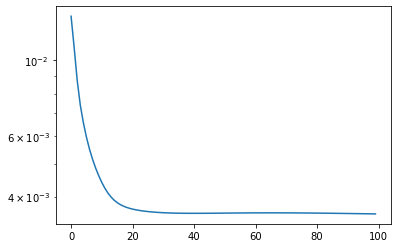

In [36]:
plt.plot(loss_arr)
plt.yscale("log")

In [37]:
model.eval()
with torch.no_grad():
    model.eval()
    print(x[0])
    print(model.encoding_result(x)[0])
    print(model.forward(x)[0])

tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 

In [38]:
torch.save(model.state_dict(), '../../models/ml100k_autoencoder.pt')

## Preprocess

데이터 구조: 각 user id를 key로 가지는 dictionary. 각 key에 대한 value는 user_feature와 movie_feature를 함께 encoding한 텐서와 각각의 벡터에 따른 reward를 나타내는 array를 tuple로서 제공한다.

 - 모든 user가 많은 movie를 평가하지는 않았다. 1개에서 50개까지 다양한듯. 텐서 shape 가지고 user_id를 자르는 코드를 Environment init에 넣어주어야 할 것 같다.

In [39]:
movielens_model = Autoencoder(emb_dim=EMB_DIM)
movielens_model.load_state_dict(torch.load('../../models/ml100k_autoencoder.pt'))
movielens_model.to(device)
movielens_model.eval()

Autoencoder(
  (encoder): Linear(in_features=551, out_features=50, bias=True)
  (decoder): Linear(in_features=50, out_features=551, bias=True)
)

In [41]:
group = filtered_data_original.groupby(filtered_data_original['user_id'])

userwise_dict = {}
for user_id,df in group:
    
    movie_ids = df['movie_id'].to_numpy()
    reward   = df['reward'].to_numpy()
    
    feature = []
    user_feature = user_id_to_feature[user_id]
    for movie_id in movie_ids:
        movie_feature= movie_id_to_feature[movie_id]
        feature.append(np.outer(user_feature, movie_feature).flatten().copy())
    feature = torch.from_numpy(np.vstack(feature)).type(torch.FloatTensor).to(device)
    
    
    with torch.no_grad():
        feature = movielens_model.encoding_result(feature).to(device)
    
    userwise_dict[user_id] = (feature.cpu().numpy(),reward.copy())

In [42]:
feature,reward = userwise_dict[1]
print(feature.shape, reward.shape)
print(reward)

(38, 50) (38,)
[1 0 0 1 0 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 0 1 1 1 0 0 1 1 0 0 1 1 1 0 1 1 1
 1]


In [43]:
# Save Dictionary
import pickle

with open('userwise_dictionary.pickle', 'wb') as f:
    pickle.dump(userwise_dict, f, pickle.HIGHEST_PROTOCOL)